In [1]:
import os
from fnmatch import fnmatch
from trainData_featExt_glcm import trainData_featExt_glcm
import numpy as np
from PIL import Image
from filtering.filters import Median
from feature_extraction.glcm import Glcm
from feature_extraction.gabor import Gabor
from sklearn import svm
import sklearn
import pickle
import time
from sklearn import preprocessing

In [2]:
#Read features of training samples 
train_samples_feats_matrix_GLCM = np.load("train_samples_feats_matrix_GLCM.npy")

In [3]:
#Read features of training samples 
train_samples_feats_matrix_LBP = np.load("train_samples_feats_matrix_LBP.npy")

In [4]:
#Load features of validation samples 
valid_samples_feats_matrix_GLCM = np.load("valid_samples_feats_matrix_GLCM.npy")

In [5]:
#Read features of training samples 
valid_samples_feats_matrix_LBP = np.load("valid_samples_feats_matrix_LBP.npy")

In [6]:
#concatenating features 
train_samples_feats_matrix_glcm_lbp = np.concatenate((train_samples_feats_matrix_GLCM,train_samples_feats_matrix_LBP), axis=1)
valid_samples_feats_matrix_glcm_lbp = np.concatenate((valid_samples_feats_matrix_GLCM,valid_samples_feats_matrix_LBP), axis=1)

In [ ]:
#Train svn model from training data
t0 = time.time()
svm_model = svm.OneClassSVM(kernel='rbf', gamma=0.1, nu=0.1)
svm_model.fit(train_samples_feats_matrix_glcm_lbp)
print("traing time: ", time.time() - t0)

In [7]:
svm_model = pickle.load( open( "SVM_['GLCM', 'LBP']_[0.2, 0.1]", "rb" ))

In [8]:
#Ground truth
y1 = np.repeat(+1, 6000) #normal
y2 = np.repeat(-1, 4000) #abnormal
y = np.concatenate((y1,y2))

In [9]:
#Predict labels of training dataset
y_predict_train = svm_model.predict(train_samples_feats_matrix_glcm_lbp)
print ("training errors", y_predict_train[y_predict_train == -1].size)

('training errors', 5998)


In [10]:
#Predict labels of new data points
y_predict = svm_model.predict(valid_samples_feats_matrix_glcm_lbp)
print ("number of samples detected as outliers", y_predict[y_predict == -1].size)
print ("detected as normal", y_predict[y_predict == +1].size)

('number of samples detected as outliers', 4502)
('detected as normal', 5498)


In [11]:
y_predict_score = svm_model.decision_function(valid_samples_feats_matrix_glcm_lbp)

In [12]:
f1_binary = sklearn.metrics.f1_score(y, y_predict, pos_label =-1, average = 'binary')
f1_macro = sklearn.metrics.f1_score(y, y_predict, average = 'macro')
auc = sklearn.metrics.roc_auc_score(y, y_predict_score)
Math_Cof = sklearn.metrics.matthews_corrcoef(y, y_predict) 
tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y, y_predict).ravel()
print ("f1_binary: ", f1_binary, "f1_macro: ", f1_macro, "MAth_cof: ", Math_Cof , " auc: ", auc)
print("confusion matrix", tn, fp, fn, tp)

('f1_binary: ', 0.61044460127028932, 'f1_macro: ', 0.6611972528007386, 'MAth_cof: ', 0.32585106801586866, ' auc: ', 0.71623499999999996)
('confusion matrix', 2595, 1405, 1907, 4093)


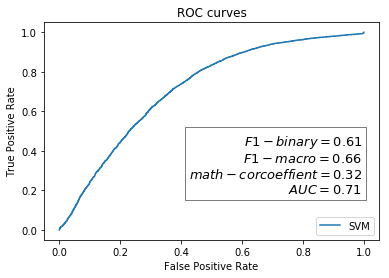

In [13]:
import matplotlib.pyplot as pl
import matplotlib
from skimage import io

fpr,tpr,thresh = sklearn.metrics.roc_curve(y,y_predict_score)

f,ax = pl.subplots(1,1)
ax.plot(fpr,tpr,label="SVM")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curves")
ax.legend(loc="lower right")
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='square', facecolor='white', alpha=0.5)

textstr = '$F1-binary=%.2f$\n$F1-macro=%.2f$\n$math-corcoeffient=%.2f$\n$AUC=%.2f$'%(0.61, 0.66, 0.32, 0.71)
# place a text box in upper left in axes coords
ax.text(0.95, 0.2, textstr, transform=ax.transAxes, fontsize=13,
    horizontalalignment='right', verticalalignment='bottom', bbox=props)

io.show()

In [14]:
f.savefig('SVM_GLCM_LBP.png')